TODO : generaliser à images 32x32, etc.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
#from waveimage import WaveImage, calc_dim, calc_U, mnist_reshape_32
from waveimage import WaveImage, calc_dim, calc_U, mnist_reshape_32

In [4]:
from scipy.stats import multivariate_normal

In [5]:
import math

In [6]:
import sys, os

In [7]:
import pickle

In [8]:
from tensorflow.examples.tutorials.mnist import input_data
#mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
mnist = input_data.read_data_sets("MNIST_data/")


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [9]:
'''def calc_U(shape, h, h_max): #dim_i, dim_j):
    dim_i, dim_j = calc_dim(shape, h, h_max)
    U = []
    for i in range(dim_i):
        for j in range(dim_j):
            U += [(i, j)]
    return U'''
from waveimage import calc_U

In [10]:
def mnist_reshape_32_buf(x):
    assert x.shape == (28 * 28,)
    image = x.reshape(28,28)
    image = np.append(np.zeros((2,28)), image, axis = 0)
    image = np.append(image, np.zeros((2,28)), axis = 0)
    image = np.append(np.zeros((32,2)), image, axis = 1)
    image = np.append(image, np.zeros((32,2)), axis = 1)
    return image


## Creation de la base d'apprentissage

In [11]:
if not os.path.isfile("mnist-waveimage-train-mu-Sigma-rho.pkl"):
    
    B_train = []
    for i in range(len(mnist.train.images)):
        if i % 1000 == 0 :
            sys.stdout.write('\rstep %d' % i) 
            sys.stdout.flush()
        c = mnist.train.labels[i]
        image = mnist_reshape_32(mnist.train.images[i])
        w = WaveImage(image = image)
        data = w.get_data()
        for h in range(w.get_h_max()):
            data_h = w.get_data()[h]
            for u in data_h:
                v = data_h[u]
                B_train += [(v,(c,h,u))]   
                
    ### Dictionnaire (Base d'apprentissage)    
    
    Data_train = [[],[],[],[],[],[],[],[],[],[]]
    for c in range(10):
        Data_train[c] = [{},{},{},{},{},{}] 

    for d in B_train:
        v = d[0]
        c = d[1][0]
        h = d[1][1]
        u = d[1][2]
        if u in Data_train[c][h]:
            Data_train[c][h][u] += [v]
        else:
            Data_train[c][h][u] = [v]
            
    ### Probas elementaires         
    mu = []
    Sigma = []
    rho = []
    for c in range(10):
        mu += [{}]
        Sigma += [{}]
        rho += [{}]
        for h in range(0,6):
            mu[c][h] = {}
            Sigma[c][h] = {}
            rho[c][h] = {}
            for u in calc_U((32, 32), h, 6):
                if u in Data_train[c][h]:
                    data = []
                    cpt = 0
                    for v in Data_train[c][h][u]:
                        if np.linalg.norm(v) < 1e-16:
                            cpt += 1
                        else:
                            data += [v]
                    #if h == -1 :
                    #    print len(data)
                    if len(data) > 1:
                        mu[c][h][u] = np.mean(data, 0) #Data[c][h][u],0)
                        Sigma[c][h][u] = np.cov(np.array(data).T) #Data[c][h][u]).T)
                        rho[c][h][u] = float(cpt) / len(Data_train[c][h][u])
                    else:
                        mu[c][h][u] = np.zeros(3)
                        Sigma[c][h][u] = np.zeros((3,3))
                        rho[c][h][u] = 1.
    del B_train, Data_train 
    pickle.dump((mu, Sigma, rho),  open("mnist-waveimage-train-mu-Sigma-rho.pkl", "wb"))
else:
    mu, Sigma, rho = pickle.load(open("mnist-waveimage-train-mu-Sigma-rho.pkl", "rb"))

nb_pos = 1 + 1 * 1 + 2 * 2 + 4 * 4 + 8 * 8 + 16 * 16
print "# weak classifiers (# pos):", nb_pos
print "# total examples :", len(B_train)
print "# total examples / weak classifier :", len(B_train) / nb_pos

# weak classifiers (# pos): 342
# total examples : 18810000
# total examples / weak classifier : 55000

## Base de test

In [12]:
B_test = []
for i in range(len(mnist.test.images)):
    if i % 1000 == 0 :
        sys.stdout.write('\rstep %d' % i) 
        sys.stdout.flush()
    c = mnist.test.labels[i]
    image = mnist_reshape_32(mnist.test.images[i])
    w = WaveImage(image = image)
    data = w.get_data()
    for h in range(w.get_h_max()):
        data_h = w.get_data()[h]
        for u in data_h:
            v = data_h[u]
            B_test += [(v,(c,h,u))]                
            

step 9000

### Dictionnaire (Base de test)

In [13]:
Data_test = [[],[],[],[],[],[],[],[],[],[]]
for c in range(10):
    Data_test[c] = [{},{},{},{},{},{}] 
    
for d in B_test:
    v = d[0]
    c = d[1][0]
    h = d[1][1]
    u = d[1][2]
    if u in Data_test[c][h]:
        Data_test[c][h][u] += [v]
    else:
        Data_test[c][h][u] = [v]

# Construction du réseau

In [43]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [14]:
def wave_tensor_data(batch_x):
    batch_size, _ = batch_x.shape
    wave_tensor = {}
    for h in range(6):
        if h == 0:
            h_size = 1
            wave_tensor[h] = np.zeros((batch_size, h_size, h_size, 1))
        else:
            h_size = 2**(h - 1)
            wave_tensor[h] = np.zeros((batch_size, h_size, h_size, 3))
    for num_batch in range(batch_size):
        image = mnist_reshape_32(batch_x[num_batch])
        w = WaveImage(image = image)
        for h in range(w.get_h_max()):
            data_h = w.get_data()[h]
            if h == 0:
                wave_tensor[h][num_batch][0][0][0] = data_h[(0,0)]
            else:
                for u in data_h:
                    wave_tensor[h][num_batch][u[0]][u[1]][:] = data_h[u]
    return wave_tensor

In [88]:
def init_test_tensor(BATCH_SIZE = 1):
    test_tensor = {}
    test_tensor[5] = np.zeros((BATCH_SIZE, DIM_5, DIM_5, DEPTH_WAV))
    test_tensor[4] = np.zeros((BATCH_SIZE, DIM_4, DIM_4, DEPTH_WAV))
    test_tensor[3] = np.zeros((BATCH_SIZE, DIM_3, DIM_3, DEPTH_WAV))
    test_tensor[2] = np.zeros((BATCH_SIZE, DIM_2, DIM_2, DEPTH_WAV))
    test_tensor[1] = np.zeros((BATCH_SIZE, DIM_1, DIM_1, DEPTH_WAV))
    test_tensor[0] = np.zeros((BATCH_SIZE, 1, 1, 1))
    return test_tensor

In [89]:
def fill_test_tensor(v, h, u, test_tensor, BATCH_SIZE = 1):
    test_tensor[h][0][u[0]][u[1]][:] = v

In [61]:
def copy_test_tensor(test_tensor):
    test_tensor_copy = {}
    test_tensor_copy[5] = np.copy(test_tensor[5])
    test_tensor_copy[4] = np.copy(test_tensor[4])
    test_tensor_copy[3] = np.copy(test_tensor[3])
    test_tensor_copy[2] = np.copy(test_tensor[2])
    test_tensor_copy[1] = np.copy(test_tensor[1])
    test_tensor_copy[0] = np.copy(test_tensor[0])
    return test_tensor_copy

In [15]:
class Obj:
    pass

In [16]:
params = Obj()
params.batch_size = 100

In [17]:
batch = mnist.train.next_batch(params.batch_size)
wave_tensor = wave_tensor_data(batch[0])

Construction 
+ 5 couches convolutionnelles : 16 x 16 --> 8 x 8 ; 8 x 8 --> 4 x 4 etc
+ 1 couche FC

In [18]:
DEPTH_WAV = 3

DIM_5 = 16
WIDTH = 2

DEPTH_4 = 32
DIM_4 = DIM_5 / WIDTH # 8

DEPTH_3 = 64
DIM_3 = DIM_4 / WIDTH # 4

DEPTH_2 = 128
DIM_2 = DIM_3 / WIDTH # 2

DEPTH_1 = 256
DIM_1 = DIM_2 / WIDTH # 1

DIM_HIDDEN = 500

NB_LABEL = 10

STD = 1.

In [19]:
nb_param_54 = (DEPTH_WAV * WIDTH * WIDTH) * DEPTH_4
nb_param_43 = (DEPTH_4 * WIDTH * WIDTH) * DEPTH_3
nb_param_32 = (DEPTH_3 * WIDTH * WIDTH) * DEPTH_2
nb_param_21 = (DEPTH_2 * WIDTH * WIDTH) * DEPTH_1
nb_param_1h = (DEPTH_1 + DEPTH_WAV + 1) * DIM_HIDDEN
nb_param_hr = DIM_HIDDEN * NB_LABEL
print (nb_param_54, nb_param_43, nb_param_32, nb_param_21, nb_param_1h, nb_param_hr)

(384, 8192, 32768, 131072, 130000, 5000)


In [20]:
DEPTH_1 + DEPTH_2 + DEPTH_3 + DEPTH_4 + DEPTH_WAV + 1

484

In [21]:
def weight_variable(shape, stddev = 0.1, name = "dummy", reuse = False):
    #initial = tf.truncated_normal(shape, stddev=0.1)
    #initial = tf.zeros(shape)
    if reuse:
        return tf.get_variable(name)
    else:
        initial = tf.random_normal(shape, stddev = stddev)
        return tf.Variable(initial, name = name)

### placeholders

In [22]:
x_5 = tf.placeholder(tf.float32, shape=[None, DIM_5, DIM_5, DEPTH_WAV])
x_4 = tf.placeholder(tf.float32, shape=[None, DIM_4, DIM_4, DEPTH_WAV])
x_3 = tf.placeholder(tf.float32, shape=[None, DIM_3, DIM_3, DEPTH_WAV])
x_2 = tf.placeholder(tf.float32, shape=[None, DIM_2, DIM_2, DEPTH_WAV])
x_1 = tf.placeholder(tf.float32, shape=[None, DIM_1, DIM_1, DEPTH_WAV])
x_0 = tf.placeholder(tf.float32, shape=[None, 1, 1, 1])
y = tf.placeholder(tf.float32, shape=[None, 10])
keep_prob = tf.placeholder(tf.float32)
batch_phase = tf.placeholder(tf.bool, name='bn_phase')

### Layers

#### 5 --> 4

In [23]:
# Paramètres
W_conv_54_flux1 = weight_variable([WIDTH, WIDTH, DEPTH_WAV, DEPTH_4], \
                            stddev = STD / (WIDTH * WIDTH * DEPTH_WAV), \
                            name = "W_conv_54_flux1")
# Graph construction
h_conv_4_flux1 = tf.nn.conv2d(x_5, W_conv_54_flux1, strides=[1, 2, 2, 1], padding='VALID', name='h_conv_4_flux1') 
#h_conv_4_flux1 = tf.nn.conv2d(x_5, W_conv_54_flux1, strides=[1, 1, 1, 1], padding='SAME', name='h_conv_4_flux1') 
#h_pool_4_flux1 = tf.nn.max_pool(h_conv_4_flux1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='h_pool_4_flux1')
#h_pool_4_bn_flux1 = tf.contrib.layers.batch_norm(h_pool_4_flux1, center=True, scale=True, is_training=batch_phase, scope='h_pool_4_flux1', updates_collections=None)
z_conv_4_flux1 = tf.nn.relu(h_conv_4_flux1)

#h_conv_4 = tf.nn.conv2d(x_5, W_conv_54, strides=[1, WIDTH, WIDTH, 1], padding='VALID', name='h_conv_4') 
#h_conv_4_bn = tf.contrib.layers.batch_norm(h_conv_4, center=True, scale=True, is_training=batch_phase, scope='h_conv_4', updates_collections=None)
#z_conv_4 = tf.nn.relu(h_conv_4_bn)

#cat_conv_4 = tf.concat((z_conv_4, x_4), axis = 3)


#### 4 --> 3

In [24]:
# Paramètres
W_conv_43_flux1 = weight_variable([WIDTH, WIDTH, DEPTH_4, DEPTH_3],\
                            stddev = STD / (WIDTH * WIDTH * DEPTH_4), \
                            name = "W_conv_43_flux1")

h_conv_3_flux1 = tf.nn.conv2d(z_conv_4_flux1, W_conv_43_flux1, strides=[1, 2, 2, 1], padding='VALID', name='h_conv_3_flux1') 
#h_conv_3_flux1 = tf.nn.conv2d(z_conv_4_flux1, W_conv_43_flux1, strides=[1, 1, 1, 1], padding='SAME', name='h_conv_3_flux1') 
#h_pool_3_flux1 = tf.nn.max_pool(h_conv_3_flux1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='h_pool_3_flux1')
#h_pool_3_bn_flux1 = tf.contrib.layers.batch_norm(h_pool_3_flux1, center=True, scale=True, is_training=batch_phase, scope='h_pool_3_flux1', updates_collections=None)
z_conv_3_flux1 = tf.nn.relu(h_conv_3_flux1)

# Graph construction
#h_conv_3 = tf.nn.conv2d(cat_conv_4, W_conv_43, strides=[1, WIDTH, WIDTH, 1], padding='VALID', name='h_conv_3') 
#h_conv_3_bn = tf.contrib.layers.batch_norm(h_conv_3, center=True, scale=True, is_training=batch_phase, scope='h_conv_3', updates_collections=None)
#z_conv_3 = tf.nn.relu(h_conv_3_bn)

#cat_conv_3 = tf.concat((z_conv_3, x_3), axis = 3)

W_conv_43_flux2 = weight_variable([WIDTH, WIDTH, DEPTH_WAV, DEPTH_4],\
                            stddev = STD / (WIDTH * WIDTH * DEPTH_WAV), \
                            name = "W_conv_43_flux1")

h_conv_3_flux2 = tf.nn.conv2d(x_4, W_conv_43_flux2, strides=[1, 2, 2, 1], padding='VALID', name='h_conv_3_flux2') 
#h_conv_3_flux2 = tf.nn.conv2d(x_4, W_conv_43_flux2, strides=[1, 1, 1, 1], padding='SAME', name='h_conv_3_flux2') 
#h_pool_3_flux2 = tf.nn.max_pool(h_conv_3_flux2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='h_pool_3_flux2')
#h_pool_3_bn_flux2 = tf.contrib.layers.batch_norm(h_pool_3_flux2, center=True, scale=True, is_training=batch_phase, scope='h_pool_3_flux2', updates_collections=None)
z_conv_3_flux2 = tf.nn.relu(h_conv_3_flux2)


#### 3 --> 2

In [25]:
# Paramètres
W_conv_32_flux1 = weight_variable([WIDTH, WIDTH, DEPTH_3 , DEPTH_2],\
                            stddev = STD / (WIDTH * WIDTH * DEPTH_3 ), \
                            name = "W_conv_32_flux1")

# Graph construction
h_conv_2_flux1 = tf.nn.conv2d(z_conv_3_flux1, W_conv_32_flux1, strides=[1, 2, 2, 1], padding='VALID', name='h_conv_2_flux1') 
#h_conv_2_flux1 = tf.nn.conv2d(z_conv_3_flux1, W_conv_32_flux1, strides=[1, 1, 1, 1], padding='SAME', name='h_conv_2_flux1') 
#h_pool_2_flux1 = tf.nn.max_pool(h_conv_2_flux1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='h_pool_2_flux1')
#h_pool_2_bn_flux1 = tf.contrib.layers.batch_norm(h_pool_2_flux1, center=True, scale=True, is_training=batch_phase, scope='h_pool_2_flux1', updates_collections=None)
z_conv_2_flux1 = tf.nn.relu(h_conv_2_flux1)

#h_conv_2 = tf.nn.conv2d(cat_conv_3, W_conv_32, strides=[1, WIDTH, WIDTH, 1], padding='VALID', name='h_conv_2') 
#h_conv_2_bn = tf.contrib.layers.batch_norm(h_conv_2, center=True, scale=True, is_training=batch_phase, scope='h_conv_2', updates_collections=None)
#z_conv_2 = tf.nn.relu(h_conv_2_bn)

#cat_conv_2 = tf.concat((z_conv_2, x_2), axis = 3)

W_conv_32_flux2 = weight_variable([WIDTH, WIDTH, DEPTH_4 , DEPTH_3],\
                            stddev = STD / (WIDTH * WIDTH * DEPTH_4 ), \
                            name = "W_conv_32_flux1")

# Graph construction
h_conv_2_flux2 = tf.nn.conv2d(z_conv_3_flux2, W_conv_32_flux2, strides=[1, 2, 2, 1], padding='VALID', name='h_conv_2_flux2') 
#h_conv_2_flux2 = tf.nn.conv2d(z_conv_3_flux2, W_conv_32_flux2, strides=[1, 1, 1, 1], padding='SAME', name='h_conv_2_flux2') 
#h_pool_2_flux2 = tf.nn.max_pool(h_conv_2_flux2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='h_pool_2_flux2')
#h_pool_2_bn_flux2 = tf.contrib.layers.batch_norm(h_pool_2_flux2, center=True, scale=True, is_training=batch_phase, scope='h_pool_2_flux2', updates_collections=None)
z_conv_2_flux2 = tf.nn.relu(h_conv_2_flux2)

W_conv_32_flux3 = weight_variable([WIDTH, WIDTH, DEPTH_WAV , DEPTH_4],\
                            stddev = STD / (WIDTH * WIDTH * DEPTH_WAV ), \
                            name = "W_conv_32_flux3")

# Graph construction
h_conv_2_flux3 = tf.nn.conv2d(x_3, W_conv_32_flux3, strides=[1, 2, 2, 1], padding='VALID', name='h_conv_2_flux3') 
#h_conv_2_flux3 = tf.nn.conv2d(x_3, W_conv_32_flux3, strides=[1, 1, 1, 1], padding='SAME', name='h_conv_2_flux3') 
#h_pool_2_flux3 = tf.nn.max_pool(h_conv_2_flux3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='h_pool_2_flux3')
#h_pool_2_bn_flux3 = tf.contrib.layers.batch_norm(h_pool_2_flux3, center=True, scale=True, is_training=batch_phase, scope='h_pool_2_flux3', updates_collections=None)
z_conv_2_flux3 = tf.nn.relu(h_conv_2_flux3)



#### 2 --> 1

In [26]:
# Paramètres
W_conv_21_flux1 = weight_variable([WIDTH, WIDTH, DEPTH_2, DEPTH_1],\
                            stddev = STD / (WIDTH * WIDTH * DEPTH_2), \
                            name = "W_conv_21_flux1")

h_conv_1_flux1 = tf.nn.conv2d(z_conv_2_flux1, W_conv_21_flux1, strides=[1, 2, 2, 1], padding='VALID', name='h_conv_1_flux1') 
#h_conv_1_flux1 = tf.nn.conv2d(z_conv_2_flux1, W_conv_21_flux1, strides=[1, 1, 1, 1], padding='SAME', name='h_conv_1_flux1') 
#h_pool_1_flux1 = tf.nn.max_pool(h_conv_1_flux1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='h_pool_1_flux1')
#h_pool_1_bn_flux1 = tf.contrib.layers.batch_norm(h_pool_1_flux1, center=True, scale=True, is_training=batch_phase, scope='h_pool_1_flux1', updates_collections=None)
z_conv_1_flux1 = tf.nn.relu(h_conv_1_flux1)

# Graph construction
#h_conv_1 = tf.nn.conv2d(cat_conv_2, W_conv_21, strides=[1, WIDTH, WIDTH, 1], padding='VALID', name='h_conv_1') 
#h_conv_1_bn = tf.contrib.layers.batch_norm(h_conv_1, center=True, scale=True, is_training=batch_phase, scope='h_conv_1', updates_collections=None)
#z_conv_1 = tf.nn.relu(h_conv_1_bn)

W_conv_21_flux2 = weight_variable([WIDTH, WIDTH, DEPTH_3, DEPTH_2],\
                            stddev = STD / (WIDTH * WIDTH * DEPTH_3), \
                            name = "W_conv_21_flux2")

h_conv_1_flux2 = tf.nn.conv2d(z_conv_2_flux2, W_conv_21_flux2, strides=[1, 2, 2, 1], padding='VALID', name='h_conv_1_flux2') 
#h_conv_1_flux2 = tf.nn.conv2d(z_conv_2_flux2, W_conv_21_flux2, strides=[1, 1, 1, 1], padding='SAME', name='h_conv_1_flux2') 
#h_pool_1_flux2 = tf.nn.max_pool(h_conv_1_flux2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='h_pool_1_flux2')
#h_pool_1_bn_flux2 = tf.contrib.layers.batch_norm(h_pool_1_flux2, center=True, scale=True, is_training=batch_phase, scope='h_pool_1_flux2', updates_collections=None)
z_conv_1_flux2 = tf.nn.relu(h_conv_1_flux2)

##

W_conv_21_flux3 = weight_variable([WIDTH, WIDTH, DEPTH_4, DEPTH_3],\
                            stddev = STD / (WIDTH * WIDTH * DEPTH_4), \
                            name = "W_conv_21_flux3")

h_conv_1_flux3 = tf.nn.conv2d(z_conv_2_flux3, W_conv_21_flux3, strides=[1, 2, 2, 1], padding='VALID', name='h_conv_1_flux2') 
#h_conv_1_flux3 = tf.nn.conv2d(z_conv_2_flux3, W_conv_21_flux3, strides=[1, 1, 1, 1], padding='SAME', name='h_conv_1_flux2') 
#h_pool_1_flux3 = tf.nn.max_pool(h_conv_1_flux3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='h_pool_1_flux3')
#h_pool_1_bn_flux3 = tf.contrib.layers.batch_norm(h_pool_1_flux3, center=True, scale=True, is_training=batch_phase, scope='h_pool_1_flux3', updates_collections=None)
z_conv_1_flux3 = tf.nn.relu(h_conv_1_flux3)

##

W_conv_21_flux4 = weight_variable([WIDTH, WIDTH, DEPTH_WAV, DEPTH_4],\
                            stddev = STD / (WIDTH * WIDTH * DEPTH_WAV), \
                            name = "W_conv_21_flux4")

h_conv_1_flux4 = tf.nn.conv2d(x_2, W_conv_21_flux4, strides=[1, 2, 2, 1], padding='VALID', name='h_conv_1_flux4') 
#h_conv_1_flux4 = tf.nn.conv2d(x_2, W_conv_21_flux4, strides=[1, 1, 1, 1], padding='SAME', name='h_conv_1_flux4') 
#h_pool_1_flux4 = tf.nn.max_pool(h_conv_1_flux4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='h_pool_1_flux4')
#h_pool_1_bn_flux4 = tf.contrib.layers.batch_norm(h_pool_1_flux4, center=True, scale=True, is_training=batch_phase, scope='h_pool_1_flux4', updates_collections=None)
z_conv_1_flux4 = tf.nn.relu(h_conv_1_flux4)

##

#cat_conv_1 = tf.concat((z_conv_1_flux1, z_conv_1_flux2, z_conv_1_flux3, z_conv_1_flux4, x_1, x_0), axis = 3)
#z_flat1 = tf.reshape(cat_conv_1, [-1, DEPTH_1 + DEPTH_2 + DEPTH_3 + DEPTH_4 + DEPTH_WAV + 1])#


### simple comb

In [27]:
z_conv_1_flux5 = tf.concat((x_1, x_0), axis = 3)
W_hidden_flux5 = weight_variable([DEPTH_WAV + 1, DIM_HIDDEN], stddev = STD / (DEPTH_WAV + 1), name = "W_hidden_flux5")
h_hidden_flux5 = tf.matmul(tf.reshape(z_conv_1_flux5, [-1, DEPTH_WAV + 1]), W_hidden_flux5)
z_hidden_flux5 = tf.nn.relu(h_hidden_flux5)

z_concat_4 = tf.concat((tf.reshape(z_conv_1_flux4, [-1, DEPTH_4]), z_hidden_flux5), axis = 1)
W_hidden_flux4 = weight_variable([DEPTH_4 + DIM_HIDDEN, DIM_HIDDEN], stddev = STD / (DEPTH_4 + DIM_HIDDEN), name = "W_hidden_flux2")
h_hidden_flux4 = tf.matmul(z_concat_4, W_hidden_flux4)
z_hidden_flux4 = tf.nn.relu(h_hidden_flux4)

z_concat_3 = tf.concat((tf.reshape(z_conv_1_flux3, [-1, DEPTH_3]), z_hidden_flux4), axis = 1)
W_hidden_flux3 = weight_variable([DEPTH_3 + DIM_HIDDEN, DIM_HIDDEN], stddev = STD / (DEPTH_3 + DIM_HIDDEN), name = "W_hidden_flux3")
h_hidden_flux3 = tf.matmul(z_concat_3, W_hidden_flux3)
z_hidden_flux3 = tf.nn.relu(h_hidden_flux3)

z_concat_2 = tf.concat((tf.reshape(z_conv_1_flux2, [-1, DEPTH_2]), z_hidden_flux3), axis = 1)
W_hidden_flux2 = weight_variable([DEPTH_2 + DIM_HIDDEN, DIM_HIDDEN], stddev = STD / (DEPTH_2 + DIM_HIDDEN), name = "W_hidden_flux2")
h_hidden_flux2 = tf.matmul(z_concat_2, W_hidden_flux2)
z_hidden_flux2 = tf.nn.relu(h_hidden_flux2)

z_concat_1 = tf.concat((tf.reshape(z_conv_1_flux1, [-1, DEPTH_1]), z_hidden_flux2), axis = 1)
W_hidden_flux1 = weight_variable([DEPTH_1 + DIM_HIDDEN, DIM_HIDDEN], stddev = STD / (DEPTH_1 + DIM_HIDDEN), name = "W_hidden_flux1")
h_hidden_flux1 = tf.matmul(z_concat_1, W_hidden_flux1)
z_hidden_flux1 = tf.nn.relu(h_hidden_flux1)

#z_hidden_concat = tf.concat((z_hidden_flux1, z_hidden_flux2, z_hidden_flux3, z_hidden_flux4, z_hidden_flux5), axis = 1)
W_hidden = weight_variable([DIM_HIDDEN, DIM_HIDDEN], stddev = STD / DIM_HIDDEN, name = "W_hidden")
h_hidden = tf.matmul(z_hidden_flux1, W_hidden)
z_hidden = tf.nn.relu(h_hidden)
z_hidden_drop = tf.nn.dropout(z_hidden, keep_prob)

#### hidden FC layer

In [28]:
#W_hidden = weight_variable([DEPTH_1 + DEPTH_2 + DEPTH_3 + DEPTH_4 + DEPTH_WAV + 1, DIM_HIDDEN], stddev = STD / (DEPTH_1 + DEPTH_2 + DEPTH_3 + DEPTH_4 + DEPTH_WAV + 1), name = "W_hidden")
#h_hidden = tf.matmul(z_flat1, W_hidden)
#z_hidden = tf.nn.relu(h_hidden)
#z_hidden_drop = tf.nn.dropout(z_hidden, keep_prob)

#### readout layer

In [29]:
W_readout = weight_variable([DIM_HIDDEN, NB_LABEL], stddev = STD / DIM_HIDDEN, name = "W_readout")
y_hat_logit = tf.matmul(z_hidden_drop, W_readout)

### Loss graph¶

In [30]:
classif_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_hat_logit))

#l1_regularizer = tf.contrib.layers.l1_regularizer(
#   scale=0.005, scope=None
#)
#weights = tf.trainable_variables() # all vars of your graph
#regularization_penalty = tf.contrib.layers.apply_regularization(l1_regularizer, weights)

regularized_loss = classif_loss #+ regularization_penalty # this loss needs to be min

### Train graph¶

In [31]:
train = tf.train.AdamOptimizer(1e-3).minimize(regularized_loss)

### Evaluation graph

In [32]:
correct_prediction = tf.equal(tf.argmax(y_hat_logit, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Training session

In [33]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

In [34]:
mem = Obj()
mem.num_epoch = []
mem.classif_eval = []


In [35]:
params.n_epochs = 100000

In [36]:
file_name = "models/mnist-waveimage-CNN-parallel-comb-500"

if not os.path.isfile(file_name + ".ckpt.index"):
    for num_epoch in range (params.n_epochs):
        if num_epoch % 10 == 0:
            mem.num_epoch += [num_epoch]
            x_test, y_test = mnist.test.next_batch(params.batch_size)
            wave_tensor = wave_tensor_data(x_test)
            classif_eval = accuracy.eval(feed_dict={x_5: wave_tensor[5],\
                                                    x_4: wave_tensor[4],\
                                                    x_3: wave_tensor[3],\
                                                    x_2: wave_tensor[2],\
                                                    x_1: wave_tensor[1],\
                                                    x_0: wave_tensor[0],\
                                                    y: y_test,\
                                                    keep_prob: 1,\
                                                    batch_phase:False})
            mem.classif_eval += [classif_eval]
            sys.stdout.write('\rstep %d\t classif : %.5f' \
                             % (num_epoch, \
                                classif_eval))
        if num_epoch % 1000 == 0:
            saver.save(sess,          file_name + ".ckpt")
            pickle.dump(mem,     open(file_name + "_mem.pkl", "wb"))
        batch_x, batch_y = mnist.train.next_batch(params.batch_size) 
        wave_tensor = wave_tensor_data(batch_x)
        train.run(feed_dict={x_5: wave_tensor[5],\
                              x_4: wave_tensor[4],\
                              x_3: wave_tensor[3],\
                              x_2: wave_tensor[2],\
                              x_1: wave_tensor[1],\
                              x_0: wave_tensor[0],\
                              y: batch_y,\
                              keep_prob: 0.9,\
                              batch_phase:True})
else:
    saver.restore(sess, file_name + ".ckpt")
    mem = pickle.load(open(file_name + "_mem.pkl", "rb"))
    

INFO:tensorflow:Restoring parameters from models/mnist-waveimage-CNN-parallel-comb-500.ckpt


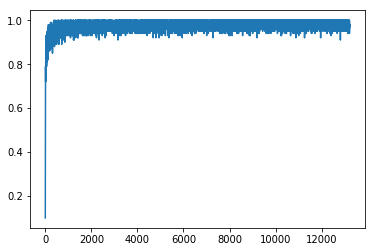

In [98]:
plt.plot(mem.classif_eval)

In [ ]:
#### Tests single prediction

In [41]:
test_tensor = {}
test_tensor[5] = np.zeros((1, DIM_5, DIM_5, DEPTH_WAV))
test_tensor[4] = np.zeros((1, DIM_4, DIM_4, DEPTH_WAV))
test_tensor[3] = np.zeros((1, DIM_3, DIM_3, DEPTH_WAV))
test_tensor[2] = np.zeros((1, DIM_2, DIM_2, DEPTH_WAV))
test_tensor[1] = np.zeros((1, DIM_1, DIM_1, DEPTH_WAV))
test_tensor[0] = np.zeros((1, 1, 1, 1))

test = y_hat_logit.eval(feed_dict={ x_5: test_tensor[5],\
                                    x_4: test_tensor[4],\
                                    x_3: test_tensor[3],\
                                    x_2: test_tensor[2],\
                                    x_1: test_tensor[1],\
                                    x_0: test_tensor[0],\
                                    keep_prob: 1,\
                                    batch_phase:False})

print test

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [45]:
x_test, y_test = mnist.test.images, mnist.test.labels
wave_tensor = wave_tensor_data(x_test)
classif_eval = accuracy.eval(feed_dict={x_5: wave_tensor[5],\
                                        x_4: wave_tensor[4],\
                                        x_3: wave_tensor[3],\
                                        x_2: wave_tensor[2],\
                                        x_1: wave_tensor[1],\
                                        x_0: wave_tensor[0],\
                                        y: y_test,\
                                        keep_prob: 1,\
                                        batch_phase:False})
sys.stdout.write('\rclassif : %.5f' \
                 % (classif_eval,))

classif : 0.98050

[[-122284.15625  907066.25    -539082.6875   443167.03125 -784730.875
   848306.6875  -424114.1875  -653379.3125   410418.71875  475477.53125]]
[ 0. -1.  0.]


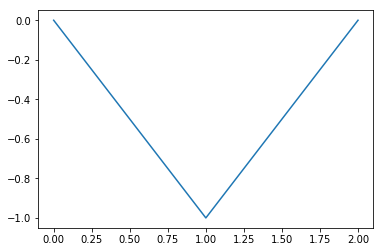

In [111]:
c = 1
ind_test = 2
u_test = (7, 7)
h_test = 5
v = Data_test[c][h_test][u_test][ind_test]

test_tensor = init_test_tensor()
y_test = np.zeros((1, 10))
y_test[0, c] = 1

fill_test_tensor(v, h_test, u_test, test_tensor)
test = y_hat_logit.eval(feed_dict={x_5: test_tensor[5],\
                                        x_4: test_tensor[4],\
                                        x_3: test_tensor[3],\
                                        x_2: test_tensor[2],\
                                        x_1: test_tensor[1],\
                                        x_0: test_tensor[0],\
                                        keep_prob: 1})
print test
plt.plot(test_tensor[h_test][0][u_test[0]][u_test[1]][:])
print v

## Predictive model

#### Liste des coordonnées par niveau : U[h], h $\in$ 0..5

In [46]:
axes = []
h_max = 6
shape = (32,32)

U = {}
for h in range(h_max):
    #U_ref = {}
    #for pos_i in axes[h]:
    #    for pos_j in axes[h]:
    #        U_ref[h] += [(pos_i, pos_j)]
    U [h] = {}
    dim_i, dim_j = calc_dim(shape, h, h_max)
    for i in range(dim_i):
        for j in range(dim_j):
            U[h][(i,j)] = 1    
    print 'Niveau ', h, ' : '
    print ' U[' , h, '] :', U[h]
    #print ' U_ref[h] :', U_ref[h]
    print ''
    

Niveau  0  : 
 U[ 0 ] : {(0, 0): 1}

Niveau  1  : 
 U[ 1 ] : {(0, 0): 1}

Niveau  2  : 
 U[ 2 ] : {(0, 1): 1, (1, 0): 1, (0, 0): 1, (1, 1): 1}

Niveau  3  : 
 U[ 3 ] : {(0, 1): 1, (1, 2): 1, (3, 2): 1, (0, 0): 1, (3, 3): 1, (3, 0): 1, (3, 1): 1, (2, 1): 1, (0, 2): 1, (2, 0): 1, (1, 3): 1, (2, 3): 1, (2, 2): 1, (1, 0): 1, (0, 3): 1, (1, 1): 1}

Niveau  4  : 
 U[ 4 ] : {(7, 3): 1, (4, 7): 1, (1, 3): 1, (6, 4): 1, (3, 0): 1, (5, 4): 1, (0, 7): 1, (5, 6): 1, (2, 6): 1, (1, 6): 1, (5, 1): 1, (3, 7): 1, (2, 5): 1, (0, 3): 1, (7, 2): 1, (4, 0): 1, (1, 2): 1, (6, 7): 1, (3, 3): 1, (2, 0): 1, (7, 6): 1, (4, 4): 1, (6, 3): 1, (1, 5): 1, (3, 6): 1, (2, 2): 1, (7, 7): 1, (5, 7): 1, (5, 3): 1, (4, 1): 1, (1, 1): 1, (2, 7): 1, (3, 2): 1, (0, 0): 1, (6, 6): 1, (5, 0): 1, (7, 1): 1, (4, 5): 1, (0, 4): 1, (5, 5): 1, (1, 4): 1, (6, 0): 1, (7, 5): 1, (2, 3): 1, (2, 1): 1, (4, 2): 1, (1, 0): 1, (6, 5): 1, (3, 5): 1, (0, 1): 1, (7, 0): 1, (4, 6): 1, (5, 2): 1, (6, 1): 1, (3, 1): 1, (0, 2): 1, (7, 4): 1, (0

#### Construction d'un arbre de coordonnées multi-niveau (descendants pour (i,j) au niveau h)

In [47]:
def fils_rec(shape, h, h_max, i, j):
    
    if h < h_max :
        dim_i, dim_j = calc_dim(shape, h, h_max)
        if i < dim_i and j < dim_j :
            rep = [(h,(i,j)), [], [], [], []]
            rep[1] = fils_rec(shape, h + 1, h_max, i * 2, j * 2)
            rep[2] = fils_rec(shape, h + 1, h_max, i * 2, j * 2 + 1)
            rep[3] = fils_rec(shape, h + 1, h_max, i * 2 + 1, j * 2)
            rep[4] = fils_rec(shape, h + 1, h_max, i * 2 + 1, j * 2 + 1)
        else:
            rep = []
    else:
        rep = []
    return rep

In [48]:
U_tree = fils_rec(shape, 0, h_max, 0, 0) 
print U_tree

[(0, (0, 0)), [(1, (0, 0)), [(2, (0, 0)), [(3, (0, 0)), [(4, (0, 0)), [(5, (0, 0)), [], [], [], []], [(5, (0, 1)), [], [], [], []], [(5, (1, 0)), [], [], [], []], [(5, (1, 1)), [], [], [], []]], [(4, (0, 1)), [(5, (0, 2)), [], [], [], []], [(5, (0, 3)), [], [], [], []], [(5, (1, 2)), [], [], [], []], [(5, (1, 3)), [], [], [], []]], [(4, (1, 0)), [(5, (2, 0)), [], [], [], []], [(5, (2, 1)), [], [], [], []], [(5, (3, 0)), [], [], [], []], [(5, (3, 1)), [], [], [], []]], [(4, (1, 1)), [(5, (2, 2)), [], [], [], []], [(5, (2, 3)), [], [], [], []], [(5, (3, 2)), [], [], [], []], [(5, (3, 3)), [], [], [], []]]], [(3, (0, 1)), [(4, (0, 2)), [(5, (0, 4)), [], [], [], []], [(5, (0, 5)), [], [], [], []], [(5, (1, 4)), [], [], [], []], [(5, (1, 5)), [], [], [], []]], [(4, (0, 3)), [(5, (0, 6)), [], [], [], []], [(5, (0, 7)), [], [], [], []], [(5, (1, 6)), [], [], [], []], [(5, (1, 7)), [], [], [], []]], [(4, (1, 2)), [(5, (2, 4)), [], [], [], []], [(5, (2, 5)), [], [], [], []], [(5, (3, 4)), [], [

#### Calcul des descendants et des parents

In [49]:
def calcule_desc(U_tree, mem_h_u_todo):
    if U_tree == []:
        return []
    else :
        if U_tree[0] in mem_h_u_todo :
            rep = [U_tree[0]]
        else:
            rep = []
        if U_tree[1] != [] :
            rep += calcule_desc(U_tree[1], mem_h_u_todo)
        if U_tree[2] != [] :
            rep += calcule_desc(U_tree[2], mem_h_u_todo)
        if U_tree[3] != [] :
            rep += calcule_desc(U_tree[3], mem_h_u_todo)
        if U_tree[4] != [] :
            rep += calcule_desc(U_tree[4], mem_h_u_todo)    
        return rep

In [50]:
print calcule_desc(U_tree, [(5, (5, 7)), (4, (2, 3))])

[(4, (2, 3)), (5, (5, 7))]


In [51]:
def find_desc (U_tree, (h, u)):
    if U_tree == []:
        return None
    else :    
        if U_tree[0] == (h, u) :
            return U_tree
        else:
            desc_1 = find_desc(U_tree[1], (h, u))
            if desc_1 != None:
                return desc_1
            desc_2 = find_desc(U_tree[2], (h, u))
            if desc_2 != None:
                return desc_2
            desc_3 = find_desc(U_tree[3], (h, u))
            if desc_3 != None:
                return desc_3
            desc_4 = find_desc(U_tree[4], (h, u))
            if desc_4 != None:
                return desc_4

In [52]:
print find_desc(U_tree, (4, (2, 3)))

[(4, (2, 3)), [(5, (4, 6)), [], [], [], []], [(5, (4, 7)), [], [], [], []], [(5, (5, 6)), [], [], [], []], [(5, (5, 7)), [], [], [], []]]


In [53]:
def calcule_asc_path(h,u):
    rep = []
    for h_inf in range(h, 0, -1):
        i_inf = u[0] / (2 ** (h - h_inf))
        j_inf = u[1] / (2 ** (h - h_inf))
        rep += [(h_inf, (i_inf, j_inf))]
    # racine
    rep += [(0, (i_inf, j_inf))]
    return rep

In [54]:
print calcule_asc_path(5,(15,3))

[(5, (15, 3)), (4, (7, 1)), (3, (3, 0)), (2, (1, 0)), (1, (0, 0)), (0, (0, 0))]


#### Generators

In [70]:
def argmax_generator(c, h, u):
    test_pred = rho[c][h][u] < .5       
    if test_pred:
        return mu[c][h][u]
        #v_predictive = np.random.multivariate_normal(mu[c_predictive][h_path][u_path], Sigma[c_predictive][h_path][u_path], 1)[0]
    else:
        return np.zeros(3)

In [71]:
def monte_carlo_generator(c, h, u):
    if np.random.random() > rho[c][h][u]:
        return np.random.multivariate_normal(mu[c][h][u], Sigma[c][h][u], 1)[0]
    else:
        return np.zeros(3)

#### Utilitaires

In [72]:
def calc_pi_predictive_sorted(pi_predictive): 
    pi_predictive_sorted = {}
    for c in range(10):
        pi_predictive_sorted[c] = []
        for k in pi_predictive[c]:
            pi_predictive_sorted[c] += [(pi_predictive[c][k], k)]
        pi_predictive_sorted[c] = sorted(pi_predictive_sorted[c])
    return pi_predictive_sorted

In [73]:
def affiche_path_mnist(path_i, path_j):
    col_max = max(15, len(path_i))
    colors = plt.cm.rainbow(np.linspace(0, 1, col_max))
    b_moins = -.5
    b_plus = 31.5
    for cpt in range(len(path_i) - 1):
        plt.plot(path_j[cpt:cpt + 2],path_i[cpt:cpt + 2], color = colors[col_max - cpt - 1], linewidth= 3)
    #plt.plot(path_j,path_i,'r+',markersize=12)
    plt.xlim([b_moins,b_plus])
    plt.ylim([b_moins,b_plus])
    plt.gca().invert_yaxis()

#### Likelihood map : `lik_predictive[c][h][u]`

In [ ]:
## TODO

### Actual algorithm (see paper)

In [91]:
def prediction_based_policy(sess, test_tensor, log_score, actions_set, mem_h_u):
    # actions_set ne contient que les positions de niveau 5
    h = h_max - 1
    ## 1 ##
    z_tilde = np.argmax(log_score)
    pi_predictive_plus = {}
    ## 2 ## Utilisation de lik_predictive
    for u in actions_set:
        liste_path = calcule_asc_path(h, u)
        log_score_path = np.zeros(10)
        test_tensor_copy = copy_test_tensor(test_tensor)
        for (h_path, u_path) in liste_path[:-1]:
            if (h_path, u_path) not in mem_h_u:
                #log_score_path = update_log_score(log_score_path, lik_predictive[z_tilde][h_path][u_path])
                v_predictive = argmax_generator(z_tilde, h_path, u_path)
                fill_test_tensor(v_predictive, h_path, u_path, test_tensor_copy)
                #lik = calc_lik(v,h,u)
                #log_score = update_log_score(log_score, lik)
        log_score_path = sess.run(y_hat_logit, feed_dict={x_5: test_tensor_copy[5],\
                                                        x_4: test_tensor_copy[4],\
                                                        x_3: test_tensor_copy[3],\
                                                        x_2: test_tensor_copy[2],\
                                                        x_1: test_tensor_copy[1],\
                                                        x_0: test_tensor_copy[0],\
                                                        keep_prob: 1})
        pi_path = sess.run(tf.nn.softmax(log_score_path))[0]
        print(log_score_path)
        pi_predictive_plus[u] = pi_path[z_tilde] 
    ## 3 ##
    keys = pi_predictive_plus.keys()
    values = np.array(pi_predictive_plus.values())
    k = np.argmax(values)
    u_tilde = keys[k]
    return u_tilde

In [92]:
def scene_exploration(sess, test_tensor, z_ref, ind_test, log_score, actions_set, mem_h_u, record, \
                      POL = 'predictive', AFF = True, THRESHOLD = 1e-4):
    
    assert POL == 'predictive' or POL == 'saliency-based' or POL == 'random' or POL == 'full'
    
    if POL == 'full':
        THRESHOLD = 0
        POL = 'saliency-based'
    
    TOUR = 0
    END = False
    h = h_max - 1
    
    # saliency-based approach
    if POL == 'saliency-based':
        pi_predictive_sorted = calc_pi_predictive_sorted(pi_predictive_eff)
    
    while END == False:
        
        if AFF:
            print '************************************'
            print '******       TOUR    ' + str(TOUR + 1) + '        ******'
            print '************************************'
        
        # 1. CHOIX
        if POL == 'predictive':
            u_tilde = prediction_based_policy(sess, test_tensor, log_score, actions_set, mem_h_u)
        elif POL == 'saliency-based':
            u_tilde = saliency_based_policy(log_score, pi_predictive_sorted, mem_h_u)
        else:
            u_tilde = random_policy(log_score, mem_h_u)
        
        if AFF:
            print 'CHOIX :', u_tilde
        
        # 2. LECTURE + UPDATE
        liste_path = calcule_asc_path(h, u_tilde)
        
        for (h_path, u_path) in reversed(liste_path):
            if (h_path, u_path) not in mem_h_u:
                v = Data_test[z_ref][h_path][u_path][ind_test] 
                fill_test_tensor(v, h_path, u_path, test_tensor)
                
                #lik_path = calc_lik(v, h_path, u_path)
                #log_score = update_log_score(log_score, lik_path)
                log_score = sess.run(y_hat_logit, feed_dict={x_5: test_tensor[5],\
                                                            x_4: test_tensor[4],\
                                                            x_3: test_tensor[3],\
                                                            x_2: test_tensor[2],\
                                                            x_1: test_tensor[1],\
                                                            x_0: test_tensor[0],\
                                                            keep_prob: 1})
                pi = sess.run(tf.nn.softmax(log_score))
                
                mem_h_u += [(h_path, u_path)]
                pi = calc_pi(log_score)
                H = np.sum(- pi * np.log(pi))
                out = np.argmax(pi)
                
                if AFF :
                    print 'pi : ', pi
                    print 'out :', out
                    print 'pi[out] : ', pi[out]
                    print 'H : ', H
                
                record.mem_pi += [pi]
                record.mem_H += [H]
                record.mem_z += [out]
                record.mem_h_u += [(h_path, u_path)]
                record.nb_coeffs += 3
                
        # 3. INHIBITION OF RETURN        
        actions_set.pop(u_tilde)
        
        record.mem_u += [u_tilde]
        record.nb_saccades += 1
                
        if AFF:
            print '****', 'z :', z_ref, ', u :',u_tilde, ' ---> ', out
              
        #mem_u_final += [u]
        #mem_pi_copy += [list(mem_pi)]
        #mem_H_copy += [list(mem_H)]
        #mem_out += [out]
        #if TOUR == 50 or (TOUR >5 and pi[out] > .99999):   
        
        if TOUR == len(U[h_max - 1]) - 1 or H < THRESHOLD:
        #if TOUR == 50 or H < THRESHOLD:
            END = True
            if AFF :
                print '************************************'
                print '******         FINI          *******'
                print '************************************' 
            return out
            #mem_out_final += [out]
            #mem_turn += [TOUR]
        else:
            TOUR += 1
           
        

In [86]:
from record import Record            
from record import affiche_records   

#### Main

In [87]:
NB_TRIALS = 1

In [93]:
import time
dict_records = {}

for POL in ('predictive',):#, 'saliency-based', 'random'):
    
    dict_records[POL] = {}
    
    for THRESHOLD in (1e-1,): # 1e-2, 1e-3, 1e-4, 1e-5):
        
        records = [] 
        cpt_TRIALS = 0
        
        for z_ref in range(NB_LABEL):
            tic = time.time()
            
            #NB_TRIALS = len(Data_test[z_ref][0][(0,0)])
            
            for ind_test in range(NB_TRIALS):
                
                test_tensor = init_test_tensor(BATCH_SIZE = 1)

                # initial
                log_score = np.zeros(10)
                pi = np.ones(10) / 10
                H = np.sum(- pi * np.log(pi))

                record = Record()
                record.POL = POL
                record.THRESHOLD = THRESHOLD
                record.z_ref = z_ref
                record.mem_pi += [pi]
                record.mem_H += [H]

                # global coef --> log_score initial
                h, u = 0, (0, 0)
                mem_h_u = [(h, u)]
                v = Data_test[z_ref][h][u][ind_test]
                fill_test_tensor(v, h, u, test_tensor)
                #lik = calc_lik(v,h,u)
                #log_score = update_log_score(log_score, lik)
                log_score = sess.run(y_hat_logit, feed_dict={x_5: test_tensor[5],\
                                    x_4: test_tensor[4],\
                                    x_3: test_tensor[3],\
                                    x_2: test_tensor[2],\
                                    x_1: test_tensor[1],\
                                    x_0: test_tensor[0],\
                                    keep_prob: 1})
                pi = sess.run(tf.nn.softmax(log_score))
                H = np.sum(- pi * np.log(pi))
                z_tilde = np.argmax(pi)

                record.mem_pi += [pi]
                record.mem_H += [H]
                record.mem_z += [z_tilde]
                record.nb_coeffs += 1

                # initial actions set
                actions_set = {}
                for i in range(16):
                    for j in range(16):
                        actions_set[(i, j)] = 1

                z_final = scene_exploration(sess, test_tensor, z_ref, ind_test, log_score,\
                                            actions_set, mem_h_u, record, \
                                            POL = POL, AFF = False, THRESHOLD = THRESHOLD)
                record.z_final = z_final
                record.success = z_ref == z_final

                records += [record]

                #sys.stdout.write('\rPolicy : %s, threshold : %g, classe %d, step %d, rep : %d' \
                #                     % (POL, THRESHOLD, z_ref, ind_test, z_final)) 
                #sys.stdout.flush()
                
            toc = time.time()
            print '\rPolicy : %s, threshold : %g, classe %d, step %d, rep : %d, elapsed time : %g' \
                                % (POL, THRESHOLD, z_ref, ind_test, z_final, toc - tic)   
            cpt_TRIALS  += NB_TRIALS

        dict_records[POL][THRESHOLD] = records
        print '\n'
        print 'Nb trials :', cpt_TRIALS
        affiche_records(records)
        print '\n'
        

/usr/lib/python2.7/dist-packages/ipykernel/__main__.py:43: RuntimeWarning: divide by zero encountered in log
/usr/lib/python2.7/dist-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in multiply


[[  477522.03125     -318647.53125      -18101.375        -18545.96289062
   -763582.25         177666.546875     -89633.21875     -130225.96875
   3540099.75        2898655.25      ]]
[[ -162343.640625   -98519.609375  -321689.25      1030495.5625
   -901657.6875     662002.125       35449.71875    616077.1875    2109902.75
   3930910.5     ]]
[[  765652.125     542217.1875    449902.40625  -983579.1875   -935682.125
   -706573.0625    716281.         87723.53125  2570425.       2855094.75   ]]
[[ -310841.625    1826122.375    -237461.125   -1334756.375    -498576.09375
  -1209442.75     -848929.        273571.8125   1177999.25     2021308.375  ]]
[[   51570.61328125   439940.5           58395.25         861167.5625
   -267272.78125       19764.03125     -553961.375        922414.75
   2525392.5         3142691.        ]]
[[ -157149.828125    535187.75       -513349.21875    -403296.21875
   -488713.8125      -51459.1015625    66110.6640625    71609.375
   2736463.5        2226101.5  

[[  324889.15625   -242237.765625   269518.8125    -118566.890625
  -1149841.375     -337761.65625   -154714.96875    435604.96875   2392300.
   2761121.75    ]]
[[   51570.61328125   439940.5           58395.25         861167.5625
   -267272.78125       19764.03125     -553961.375        922414.75
   2525392.5         3142691.        ]]
[[  477522.03125     -318647.53125      -18101.375        -18545.96289062
   -763582.25         177666.546875     -89633.21875     -130225.96875
   3540099.75        2898655.25      ]]
[[  4.15069375e+04  -2.26688469e+05  -2.34975672e+05   8.71123500e+05
   -1.10182400e+06   4.19916781e+05  -6.60828125e+02   6.40407500e+05
    2.26288750e+06   3.91727900e+06]]
[[ -681134.0625   1940751.       -439565.6875  -1701552.25     -375046.28125
  -1153010.875    -803851.        121053.5625   1426222.875    2099244.5    ]]
[[   51570.61328125   439940.5           58395.25         861167.5625
   -267272.78125       19764.03125     -553961.375        922414.75
   

[[  275390.8125     172733.875     -330103.25      -261237.515625
  -1432997.25       234403.078125  -357489.6875     164144.15625   2890661.
   2271562.5     ]]
[[ -157149.828125    535187.75       -513349.21875    -403296.21875
   -488713.8125      -51459.1015625    66110.6640625    71609.375
   2736463.5        2226101.5      ]]
[[ 1126652.        824539.125    -490260.90625  1076013.75     -845763.8125
   1020043.3125   -679909.625    -244814.34375   742435.8125   1643900.375  ]]
[[  360998.53125    -277767.46875     111153.78125     274330.25
   -816160.125       229766.125      -126081.4296875   -98373.21875
   3527038.75       2681105.25     ]]
[[ -157149.828125    535187.75       -513349.21875    -403296.21875
   -488713.8125      -51459.1015625    66110.6640625    71609.375
   2736463.5        2226101.5      ]]
[[  477522.03125     -318647.53125      -18101.375        -18545.96289062
   -763582.25         177666.546875     -89633.21875     -130225.96875
   3540099.75        28

KeyboardInterrupt: 

In [94]:
test_tensor

{0: array([[[[ 4.53602969]]]]),
 1: array([[[[ 0.,  0.,  0.]]]]),
 2: array([[[[ 0.,  0.,  0.],
          [ 0.,  0.,  0.]],
 
         [[ 0.,  0.,  0.],
          [ 0.,  0.,  0.]]]]),
 3: array([[[[ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          [ 0.,  0.,  0.]],
 
         [[ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          [ 0.,  0.,  0.]],
 
         [[ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          [ 0.,  0.,  0.]],
 
         [[ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          [ 0.,  0.,  0.]]]]),
 4: array([[[[ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          [ 0.,  0.,  0.]],
 
         [[ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          [ 0.,  0.,  0.],
          [

In [95]:
test = y_hat_logit.eval(feed_dict={ x_5: test_tensor[5],\
                                    x_4: test_tensor[4],\
                                    x_3: test_tensor[3],\
                                    x_2: test_tensor[2],\
                                    x_1: test_tensor[1],\
                                    x_0: test_tensor[0],\
                                    keep_prob: 1,\
                                    batch_phase:False})

print test

[[  797189.1875       56386.2421875  -578332.875     -1279845.125
   -966177.5         826795.6875      335735.6875     -103963.375
   3814599.5        3402091.25     ]]


In [97]:
sess.run(tf.nn.softmax(test))

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.]], dtype=float32)